In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-19 21:03:50--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.18, 54.230.18.11, 54.230.18.79, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-19 21:03:50 (5.83 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


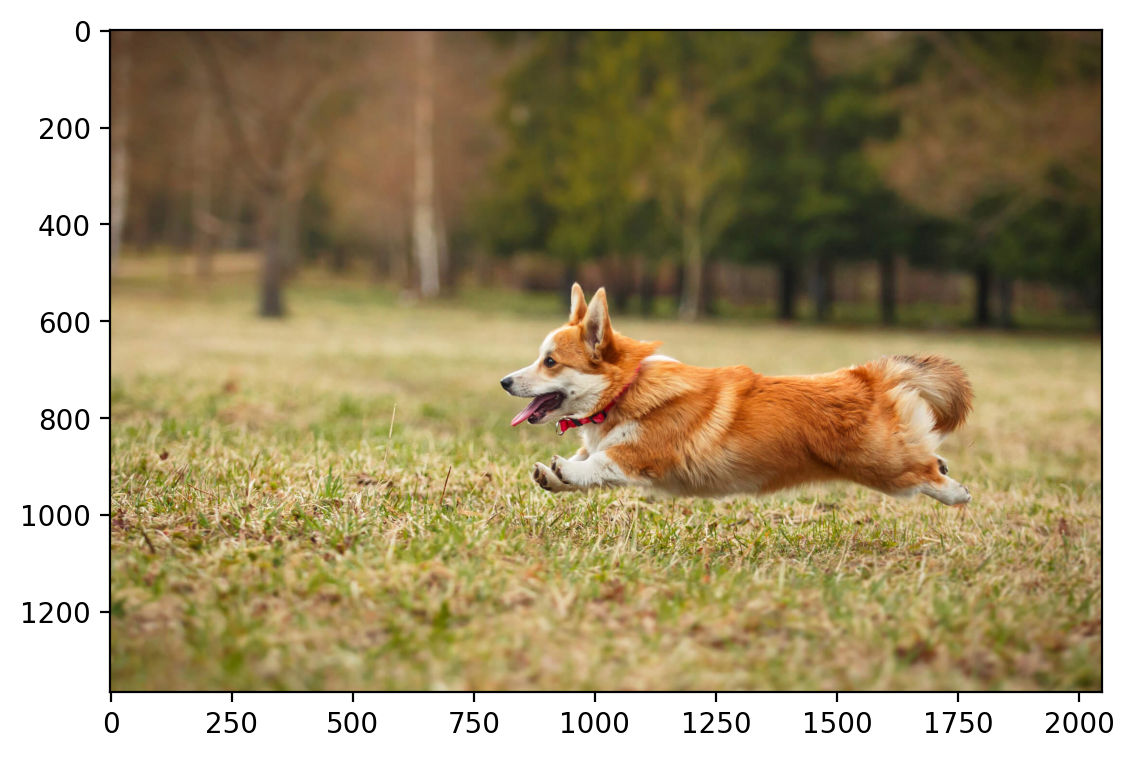

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler_img=MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled).float().to(device)

(3, 1365, 2048)


In [6]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

torch.Size([3, 400, 400])


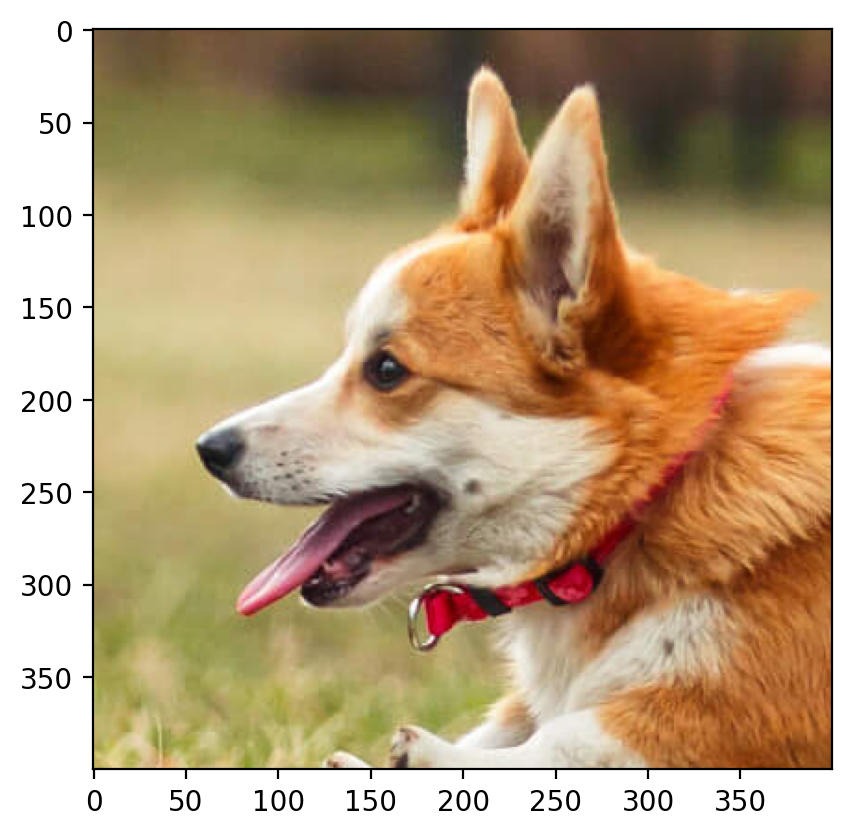

In [7]:
orig_img=torchvision.transforms.functional.crop(img_scaled,500,750,400,400)
plt.imshow(rearrange(orig_img,'c h w -> h w c').numpy())
print(orig_img.shape)

torch.Size([3, 200, 200])


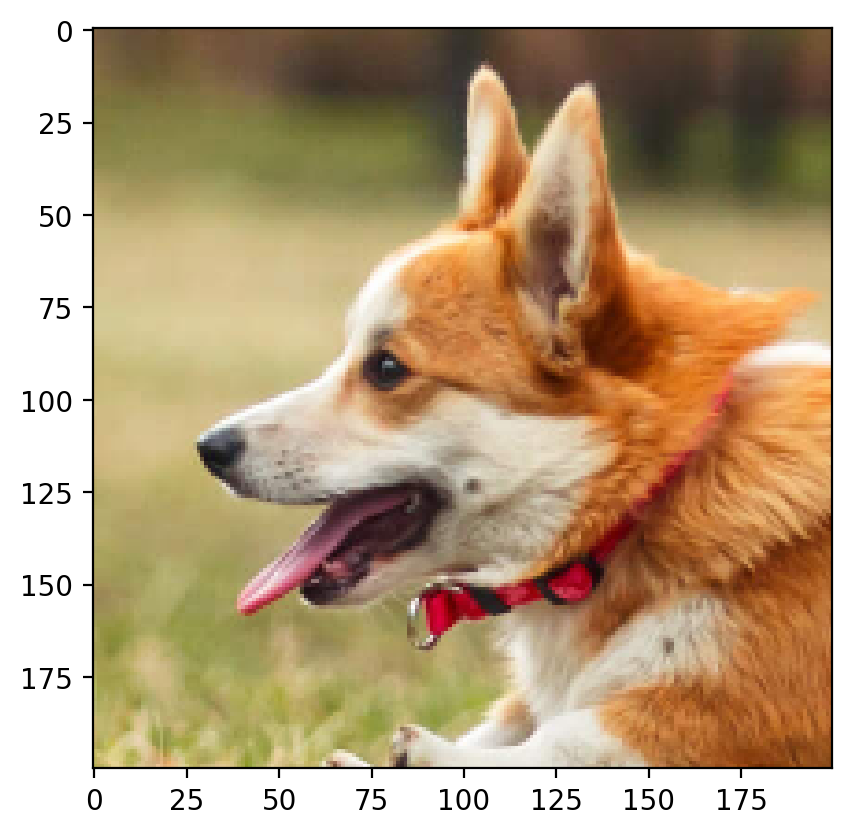

In [8]:
resized_img=cv2.resize(rearrange(orig_img,'c h w -> h w c').numpy(),(200,200))
resized_img=torch.tensor(resized_img).permute(2,0,1)
print(resized_img.shape)
plt.imshow(rearrange(resized_img,'c h w -> h w c').numpy())

In [9]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width=img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [10]:
dog_X, dog_Y = create_coordinate_map(resized_img)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

dog_X_scaled = scaler_X.transform(dog_X.cpu())

dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

dog_X_scaled = dog_X_scaled.float()

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [13]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [14]:
dog_Y.shape

torch.Size([40000, 3])

In [15]:
num_features=37500
sigma=0.008
from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
X_rff = rff.fit_transform(dog_X_scaled.cpu().numpy())
X_rff=torch.tensor(X_rff, dtype=torch.float32).to(device)


In [16]:
X_rff.shape

torch.Size([40000, 37500])

In [17]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.324026
Epoch 100 loss: 0.038063
Epoch 200 loss: 0.009387
Epoch 300 loss: 0.004706
Epoch 400 loss: 0.002647
Epoch 500 loss: 0.001547
Epoch 600 loss: 0.000936
Epoch 700 loss: 0.000590
Epoch 800 loss: 0.000392
Epoch 900 loss: 0.000279
Epoch 1000 loss: 0.000215
Epoch 1100 loss: 0.000179
Epoch 1200 loss: 0.000159
Epoch 1300 loss: 0.000148
Epoch 1400 loss: 0.000141
Epoch 1500 loss: 0.000138
Epoch 1600 loss: 0.000135
Epoch 1700 loss: 0.000134
Epoch 1800 loss: 0.000133
Epoch 1900 loss: 0.000132
Epoch 2000 loss: 0.000131
Epoch 2100 loss: 0.000131
Epoch 2200 loss: 0.000130
Epoch 2300 loss: 0.000130
Epoch 2400 loss: 0.000129


0.00012899551074951887

In [18]:
orig_dog_X, orig_dog_Y = create_coordinate_map(orig_img)

In [19]:
from sklearn import preprocessing
scaler_X_orig=preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(orig_dog_X)
orig_dog_X_scaled=scaler_X_orig.transform(orig_dog_X.cpu())
orig_dog_X_scaled=torch.tensor(orig_dog_X_scaled).to(device)
print(orig_dog_X_scaled.shape)

torch.Size([160000, 2])


In [20]:
orig_X_rff = rff.transform(orig_dog_X_scaled.cpu().numpy())
orig_X_rff=torch.tensor(orig_X_rff, dtype=torch.float32).to(device)

In [21]:
with torch.no_grad():
  y_pred=net(orig_X_rff)

In [22]:
print(y_pred.shape)

torch.Size([160000, 3])


In [23]:
res_img=y_pred.reshape(rearrange(orig_img,'c h w -> h w c').shape).permute(2,0,1)

In [24]:
print(res_img.shape)

torch.Size([3, 400, 400])


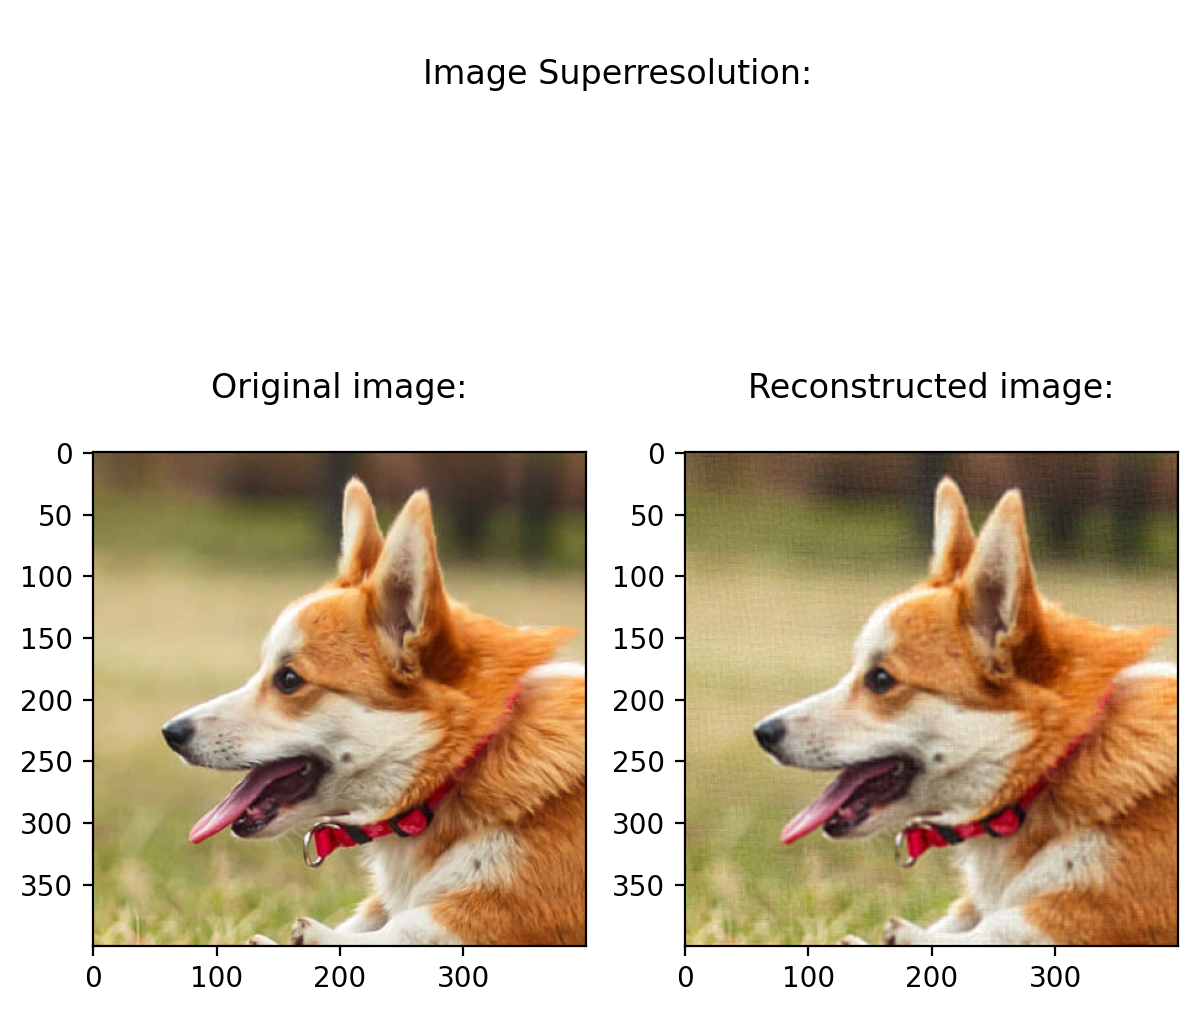

In [25]:
plt.figure(figsize=(7,7))
plt.suptitle('\nImage Superresolution:')
plt.subplot(1,2,1)
plt.title('Original image:\n')
plt.imshow(rearrange(orig_img,'c h w -> h w c'))
plt.subplot(1,2,2)
plt.imshow(rearrange(res_img,'c h w -> h w c'))
plt.title('Reconstructed image:\n')
plt.show()

In [33]:
def get_rmse(img1, img2):
    rmse= torch.sqrt(torch.mean((img1 - img2) ** 2))
    return rmse
def get_psnr(img1, img2):
    psnr= 20 * torch.log10(1 /get_rmse(img1, img2))
    return psnr

In [36]:
rmse=get_rmse(res_img,orig_img)
psnr=get_psnr(res_img,orig_img)
print('RMSE : ', rmse.item())
print('PSNR: ',psnr.item())

RMSE :  0.024098817259073257
PSNR:  32.360084533691406
